# Importing

In [242]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [243]:
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')

# Variable selection
temp = ds.votemper 
saline = ds.vosaline
date = pd.DatetimeIndex(ds['time_counter'].values)

print('The amount of zeros in salinity before flagging for', date.date[0], 'is:', np.size(saline[0,0]) - np.count_nonzero(saline[0,0]))
print('The amount of zeros in temperature before flagging for', date.date[0], 'is:', np.size(temp[0,0]) - np.count_nonzero(temp[0,0]))

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

# Apply it to the selected variables
temp = temp.where(mask[0,0]==1)
saline = saline.where(mask[0,0]==1)

print('The amount of zeros in salinity after flagging', date.date[0], 'is:', np.size(saline[0,0]) - np.count_nonzero(saline[0,0]))
print('The amount of zeros in temperature after flagging', date.date[0], 'is:', np.size(temp[0,0]) - np.count_nonzero(temp[0,0]))


The amount of zeros in salinity before flagging for 2022-03-31 is: 99846
The amount of zeros in temperature before flagging for 2022-03-31 is: 99763
The amount of zeros in salinity after flagging 2022-03-31 is: 83
The amount of zeros in temperature after flagging 2022-03-31 is: 0


# Data Wrangling with Zeros from Salinity

In [244]:
inputs = np.stack((temp[0,0].values.flatten(), saline[0,0].values.flatten()))

indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]))

inputs2 = np.transpose(inputs)
inputs2 = inputs2[indx[:,0]]


# SOM - Matrix Grid with Zeros from Salinity

In [245]:
temp_som = SOM(m=2, n=3, dim=2)
temp_som.fit(inputs2)
predictions = temp_som.predict(inputs2)

# Post processing 
unique, counts_z = np.unique(predictions, return_counts=True)
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = predictions

predictions = np.reshape(indx2,(898,398))
som_z = xr.DataArray(predictions,
                   coords = {'y': temp[0,0].y, 'x': temp[0,0].x},
                   dims = ['y','x'],
                   attrs=dict(description="Clusters of the performed self organizing map algorithm",
                              long_name ="Cluster",
                              units="count"),
                   ) 


# Data Wrangling without Zeros from Salinity

In [246]:
inputs = np.stack((temp[0,0].values.flatten(), saline[0,0].values.flatten()))

# Convert 0 to nan
inputs2 = np.where(inputs==0, np.nan, inputs)

indx = np.argwhere(~np.isnan(inputs2[0]) & ~np.isnan(inputs2[1]))

inputs2 = np.transpose(inputs2)

inputs2 = inputs2[indx[:,0]]


# SOM - Matrix Grid without Zeros from Salinity

In [247]:
temp_som = SOM(m=2, n=3, dim=2)
temp_som.fit(inputs2)
predictions = temp_som.predict(inputs2)

# Post processing 
unique, counts_nz = np.unique(predictions, return_counts=True)
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = predictions

predictions = np.reshape(indx2,(898,398))
som_nz = xr.DataArray(predictions,
                   coords = {'y': temp[0,0].y, 'x': temp[0,0].x},
                   dims = ['y','x'],
                   attrs=dict(description ="Clusters of the performed self organizing map algorithm",
                              long_name = "Cluster",                    
                              units="count"),
                   ) 


# Plotting

Text(0.5, 0.98, 'SOM clustering using temperature and salinity for 2022/03/31')

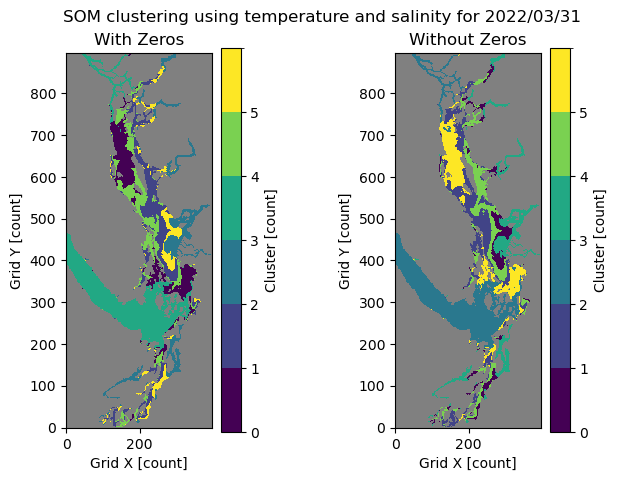

In [248]:
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('viridis', 6)
cmap.set_bad('gray')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.4)

som_z.plot.pcolormesh(ax=ax[0], cmap=cmap, levels=[0,1,2,3,4,5,6], cbar_kwargs={'ticks': [0,1,2,3,4,5]}) 
som_nz.plot.pcolormesh(ax=ax[1], cmap=cmap, levels=[0,1,2,3,4,5,6], cbar_kwargs={'ticks': [0,1,2,3,4,5]})

sa_vi.set_aspect(ax[0])
sa_vi.set_aspect(ax[1])
ax[0].title.set_text('With Zeros')
ax[1].title.set_text('Without Zeros')
test = date[0].month
fig.suptitle('SOM clustering using temperature and salinity for ' + str(date[0].year) + '/0' + str(date[0].month) + '/' + str(date[0].day))
